In [1]:
import time
import random
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import ion
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import RegressorMixin
from tensorflow.python import training
#%matplotlib inline
#%matplotlib notebook
import os 
import gc


In [2]:
class LoggingCallback(keras.callbacks.Callback):
    """Callback that logs message at end of epoch.
    """


    def __init__(self, parExpDir):
       
        self.exp_dir = parExpDir


    def on_epoch_end(self, epoch, logs=None):

        
        file_path = self.exp_dir+"/readme.txt"

        f = open(file_path, "a")
        msg = "{Epoch: %i} %s" % (epoch, ", ".join("%s: %f" % (k, v) for k, v in logs.items()))
        f.write(msg+"\n")
        f.close()



class Client():



    #resultadoTreinamento = np.eye(10)

    def __init__(self,
                 parId,
                 parTraininPath, 
                 parTestPath, 
                 parEpoch,
                 parUnits, 
                 parBatchSize, 
                 parPrevisionWindow, 
                 parStepsOut,
                 parCongestionProtocol,
                 parNumWebNodes, 
                 parRTTToRouter,
                 parExpTime,
                 parExpDir,
                 par_exp_dir_out_from_fit,
                 par_exp_dir_out_from_file,
                 par_num_rodadas):
 
      self.id = parId
      self.id_in_server=-1 #-1 indica que não foi cadastrado no servidor
      self.trainingPath=parTraininPath
      self.testPath = parTestPath
      self.T = parPrevisionWindow
      #centralServer = Server_FederatedAMA()
      #confusionMatrizModelClient = np.full((2,2), 1)
      #confusionMatrizModelServer = np.full((2,2), 2)
      self.currentConfusionMatriz =np.full((2,2), 0) # Apesar de ser obtidas a partir de listas, a matriz de comfusão é numpy
      self.weightsClientModel = []
      self.weightsServerModel = []
      #self.total_ConsolidateModels=0;
      #self.base = pd.DataFrame()
      #self.base_treinamento =  np.array([])
      #self.test_vectors = []
      #self.previsores = []
      #self.real_congestion = []
      #self.regressor = Sequential()
      self.input_shape =0;
      self.base_teste=[]
      self.len_base_teste = 0;
      self.n_steps_out = parStepsOut
      self.congestion_protocol = parCongestionProtocol
      self.mean_real_congestion = 0;
      self.mean_predicted_congestion=0;
      #self.windowMemory = parWindowMemory #substituido pela unit
      self.exp_units=parUnits
      self.exp_batch_size=parBatchSize
      self.exp_num_web_nodes=parNumWebNodes;
      self.exp_RTT_to_router=parRTTToRouter;
      self.exp_epoch=parEpoch
      self.exp_time=parExpTime
      self.exp_dir = parExpDir
      self.num_plot = 0;
      self.last_server_type_sender = "AMA" #AMA, INTERCHANGE
      self.total_model_received_form_server=0
      self.model_saves = 0
      self.deslocamento = 1;
      self.slide = 0; #guarda os avanços na base de dados, do tamanho de deslocamento
      self.exp_dir_out_from_fit = par_exp_dir_out_from_fit
      self.exp_dir_out_from_file =par_exp_dir_out_from_file
      self.num_rodadas = par_num_rodadas
      self.latest_prevision = np.empty((self.num_rodadas,1)) 
      self.real_congestion_test = np.empty((self.num_rodadas,1))
      self.training_head = 0
      self.training_tail = 50*self.T
    
      
      
    def ReadNormalizationFactors(self):
       
       ack_ewma_normalizer=1.0
       send_ewma_normalizer=1.0
       rtt_ratio_normalizer=1.0
       cwnd_normalizer=1.0
     
       file1 = open(self.exp_dir+"/normalization_factors.txt", 'r')
       Lines = file1.readlines()
       
       ack_ewma_normalizer = float(Lines[0].split()[len(Lines[0].split())-1])# split retorna uma lista com as strings da linha que estão separadas por espaço
       send_ewma_normalizer = float(Lines[1].split()[len(Lines[1].split())-1])
       rtt_ratio_normalizer=float(Lines[2].split()[len(Lines[2].split())-1])
       cwnd_normalizer=float(Lines[3].split()[len(Lines[3].split())-1])
       
       return ack_ewma_normalizer, send_ewma_normalizer, rtt_ratio_normalizer, cwnd_normalizer

 
 
      #self.centralServer.RegisterClient(self,self)

    def NormalizeFeatures(self, data, parLoadFromNotTrainedFile=False,parSequencialTraining=False):
       
       ack_ewma_normalizer=1.0
       send_ewma_normalizer=1.0
       rtt_ratio_normalizer=1.0
       cwnd_normalizer=1.0
       
       #Obtendo o RTT Ratio
       data['rtt_ratio'] = data['rtt_ratio'].div(data['rtt_ratio'].min())
       
       if(parLoadFromNotTrainedFile or parSequencialTraining): #Deve-se carregar parametros do arquivo
           ack_ewma_normalizer, send_ewma_normalizer,rtt_ratio_normalizer,cwnd_normalizer= self.ReadNormalizationFactors()
           
       else:
           ack_ewma_normalizer = data['ack_ewma(ms)'].max()
           send_ewma_normalizer=data['send_ewma(ms)'].max()
           rtt_ratio_normalizer=data['rtt_ratio'].max()
           cwnd_normalizer=data['cwnd (Bytes)'].max()
           file1 = open(self.exp_dir+"/normalization_factors.txt", 'w')
           file1.writelines("ack_ewma: "+str(ack_ewma_normalizer)+"\n")
           file1.writelines("send_ewma: "+str(send_ewma_normalizer)+"\n")
           file1.writelines("rtt_ratio: "+str(rtt_ratio_normalizer)+"\n")
           file1.writelines("cwnd (Bytes): "+str(cwnd_normalizer)+"\n")
           file1.close()
       
       print("ack_ewma_normalizer: ", ack_ewma_normalizer)
       print("send_ewma: ", send_ewma_normalizer)
       print("rtt_ratio_normalizer: ", rtt_ratio_normalizer)
       print("cwnd (Bytes): ", cwnd_normalizer)

       data['ack_ewma(ms)'] = data['ack_ewma(ms)'].div(ack_ewma_normalizer)
       data['send_ewma(ms)'] = data['send_ewma(ms)'].div(send_ewma_normalizer)
       data['rtt_ratio'] = data['rtt_ratio'].div(rtt_ratio_normalizer)
       data['cwnd (Bytes)'] = data['cwnd (Bytes)'].div(cwnd_normalizer)
       return data

    def SplitBase(self, base):
      training_base = base.iloc[0:base.shape[0]-200,:]
      teste = base.iloc[base.shape[0]-200:base.shape[0],:]
      return training_base, teste


    
    def RefreshFromServerModel(self):
      if(self.ServerModelIsBetter()):
          print("Pesos atualizados de acordo com o modelo do servidor")
          return True
      else:
          print("Pesos Mantidos de acordo com o modelo do cliente")
          return False

    def LoadTrainingDataSet(self, parSequencialTraining=False):
      base = pd.read_csv(self.trainingPath)
      base = base.dropna()
      base = self.NormalizeFeatures(base,parLoadFromNotTrainedFile=False,parSequencialTraining=parSequencialTraining)
      if(not self.slide):
          base = base.drop(labels=range(50*self.T+self.deslocamento*self.slide+self.n_steps_out-1,base.shape[0]),axis=0) 
          
      else:
          base = base.drop(labels=range(0,self.deslocamento*self.slide),axis=0)
          #base = base.drop(labels=range(10*self.T+self.deslocamento*self.slide,base.shape[0]),axis=0)
          base = base.drop(labels=range((50*self.T)+self.n_steps_out-1,base.shape[0]),axis=0)
      
      self.slide=self.slide+1
      
 
      #base_treinamento, self.base_teste = self.SplitBase(base)
      base_treinamento = base.iloc[:, [1,2,3,4,5]].values

      #base_treinamento = base.iloc[:, [1,2,3,5]].values
      #print("Veja a base de treinamento normalizada")
      #print(base_treinamento)
      #input();
      #normalizador = MinMaxScaler(feature_range=(0,1))
      #base_treinamento = normalizador.fit_transform(base_treinamento)
      #base_treinamento = base.iloc[:, [2,4,6]].values
      previsores=[]
      real_congestion = []

      #real_congestion_ahead = []

      print(base_treinamento.shape[0]) #número de linhas dos dados de treinamento
      #"-self.n_steps_out", pois, se não estoura, não dá para fazer 5 a frente a partir do último                                                                   
      for i in range(self.T, base_treinamento.shape[0]):
        end_ix = i+self.n_steps_out
        if end_ix > base_treinamento.shape[0]:
          break;
        #previsores.append(base_treinamento[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1
        previsores.append(base_treinamento[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1 e sem a informação do percentual de ocupação do buffer
        real_congestion.append(base_treinamento[(i-1)+self.n_steps_out,4])#
    
        '''
        #Se quiser repetir os últimos valores
        real_congestion_ahead.clear();
        
        for k in range (self.n_steps_out):
          if i+k < base_treinamento.shape[0]:
            #print(i+k,"---> ", base_treinamento[i+k, 3])
            real_congestion_ahead.append(base_treinamento[i+k, 4])#O resultado é do último cara
          else:
            real_congestion_ahead.append(base_treinamento[base_treinamento.shape[0]-1, 4])#O resultado é do último cara
        real_congestion.append(real_congestion_ahead.copy())
        '''
        #print(real_congestion)
        #input("real_congestion ++")
      '''
      *********************************SOBRE O RESHAPE**************************************
      Veja que nesse caso não é necessário fazer o reshape, uma vez que o array previsores , já sai
      no formato [samples, timesteps, features]
      *sample: Ajanela deslizante em T vai gerar um número de inserções em previsores, correspondente ao número de samples
      *timesteps:inserções de exatamente T arrays, que nesse caso é equivalente ao timestamps, ou seja, quantas leituras no tempo estamos 
      considerando para prever. 
      *features: T arrays de n features

      no nosso caso:

      seja

      base_treinamento = np.array([
                          [0.0618679825944638,1.48529333300134E-05,0.849658635009267,	1,	0.8],
                          [0.0618642722717276,1.29963255564132E-05,0.856697088426436,0.960369635326222,0.8],
                          [0.061861180336114,	1.13717804155358E-05,0.863735541843606,0.915095509799057,	0.78],
                          [0.0618582945295414,9.95030786359384E-06,0.870773995260775,0.892458447035475,	0.76],
                          [0.0620104177617272,8.70651048799314E-06,0.877953217746287,0.869821384271893,	0.74],
                          [0.06214357712215,  7.6182100159712E-06, 0.8851324402318,0.860208385016125,	0.72],
                          [0.0622600400302597	,6.66593154081194E-06	,0.892311662717312,0.847184321508311,	0.7],
                          [0.0623620739055063	,5.83269009821044E-06	,0.899490885202825,	0.847184321508311,	0.68],
                          [0.0624511216511761	,5.1035993896084E-06,0.906670107688337,0.847184321508311,	0.69],
                          [0.062529244557678	,4.46565835855882E-06	,0.91384933017385	,0.847184321508311,	0.78],
                          [0.0625974732702166,3.9074488405761E-06	,0.921028552659362	,0.847184321508311,	0.58],
                          [0.0626572506920783	,3.41901106601549E-06	,0.928207775144875,0.847184321508311,	0.48],
                          [0.0627096074684674	,2.99163023643782E-06	,0.935386997630387,0.847184321508311,	0.38],
                          [0.0627553681155477	,2.61767645688309E-06	,0.9425662201159,0.0226370627635822,	0.18],
                          [0.0627953571494827	,2.29048023874991E-06	,0.949745442601412,0.0226370627635822,	0.28],


      ])


      ou seja 15 samples, 4 features e uma a ser prevista. Vamos considerar T=3 e n_steps_out=4(n_steps_out=0 já é um a frente, ou seja tem que bater em T)  
      Daí só vai sobrar 15-(T+n_steps_out-1= 3+4-1) = 9 samples
      a saída será

      previsores
             1               2              3             4
    1  [[6.18679826e-02 1.48529333e-05 8.49658635e-01 1.00000000e+00]
      T [6.18642723e-02 1.29963256e-05 8.56697088e-01 9.60369635e-01]
        [6.18611803e-02 1.13717804e-05 8.63735542e-01 9.15095510e-01]] 0.7
    2  [[6.18642723e-02 1.29963256e-05 8.56697088e-01 9.60369635e-01]
      T [6.18611803e-02 1.13717804e-05 8.63735542e-01 9.15095510e-01]
        [6.18582945e-02 9.95030786e-06 8.70773995e-01 8.92458447e-01]] 0.68
    3[  [6.18611803e-02 1.13717804e-05 8.63735542e-01 9.15095510e-01]
      T [6.18582945e-02 9.95030786e-06 8.70773995e-01 8.92458447e-01]
        [6.20104178e-02 8.70651049e-06 8.77953218e-01 8.69821384e-01]] 0.69
    4[  [6.18582945e-02 9.95030786e-06 8.70773995e-01 8.92458447e-01]
      T [6.20104178e-02 8.70651049e-06 8.77953218e-01 8.69821384e-01]
        [6.21435771e-02 7.61821002e-06 8.85132440e-01 8.60208385e-01]] 0.78
    5[  [6.20104178e-02 8.70651049e-06 8.77953218e-01 8.69821384e-01]
      T [6.21435771e-02 7.61821002e-06 8.85132440e-01 8.60208385e-01]
        [6.22600400e-02 6.66593154e-06 8.92311663e-01 8.47184322e-01]] 0.58
    6[  [6.21435771e-02 7.61821002e-06 8.85132440e-01 8.60208385e-01]
      T [6.22600400e-02 6.66593154e-06 8.92311663e-01 8.47184322e-01]
        [6.23620739e-02 5.83269010e-06 8.99490885e-01 8.47184322e-01]] 0.48
    7[  [6.22600400e-02 6.66593154e-06 8.92311663e-01 8.47184322e-01]
      T [6.23620739e-02 5.83269010e-06 8.99490885e-01 8.47184322e-01]
        [6.24511217e-02 5.10359939e-06 9.06670108e-01 8.47184322e-01]] 0.38
    8[  [6.23620739e-02 5.83269010e-06 8.99490885e-01 8.47184322e-01]
      T [6.24511217e-02 5.10359939e-06 9.06670108e-01 8.47184322e-01]
        [6.25292446e-02 4.46565836e-06 9.13849330e-01 8.47184322e-01]] 0.18
    9[  [6.24511217e-02 5.10359939e-06 9.06670108e-01 8.47184322e-01]
      T [6.25292446e-02 4.46565836e-06 9.13849330e-01 8.47184322e-01]
        [6.25974733e-02 3.90744884e-06 9.21028553e-01 8.47184322e-01]] 0.28

          ou seja
          [samples,timestepes,features]

      '''
      previsores, real_congestion = np.array(previsores), np.array(real_congestion)
      '''
      print("shape previsores: ")
      print(previsores.shape)
      #input("shape dos previsores")
      print("Amostra Previsores")      
      print(previsores[0])
      print(previsores[1])
      print(previsores[2])
      #input("Amostra Previsores Exibidos acima")
      print("Real Congestion: ")
      print(real_congestion)
      #input("exibidos os Congestionamentos Reais")
      '''
      self.input_shape = previsores.shape[1]
      return previsores, real_congestion
      
    def GetModel(self):
      regressor = Sequential()
      #regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4)))# 4, pois são 4 previsores
      #regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4)))# 3, retirando o valor do preenchimento do buffer.
      #regressor.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4))))
      #regressor.add(Dropout(0.3)) #zerar 30% das entradas para evitar o overfiting

      #regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4)))
      #regressor.add(LSTM(units = 20, return_sequences = True, input_shape = (self.input_shape, 4)))
      #regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (self.input_shape, 4)))
      #regressor.add(LSTM(units = 6, return_sequences = True, input_shape = (self.input_shape, 4)))
      regressor.add(LSTM(units = 2*self.exp_units, return_sequences = True, input_shape = (self.input_shape, 4)))
      regressor.add(Dropout(0.3)) #zerar 30% das entradas para evitar o overfiting
      
      
      #regressor.add(LSTM(units = 50, return_sequences = True))
      #regressor.add(LSTM(units = 10, return_sequences = True))
      #regressor.add(LSTM(units = 6, return_sequences = True))
      regressor.add(LSTM(units = self.exp_units, return_sequences = True))
      regressor.add(Dropout(0.3))


      #regressor.add(LSTM(units = 50, return_sequences = True))
      #regressor.add(LSTM(units = 10, return_sequences = True))
      #regressor.add(LSTM(units = 6, return_sequences = True))
      regressor.add(LSTM(units = self.exp_units, return_sequences = True))
      regressor.add(Dropout(0.3))

      #regressor.add(LSTM(units = 50))
      #regressor.add(LSTM(units = 10))
      #regressor.add(LSTM(units = 6))
      regressor.add(LSTM(units = self.exp_units))
      regressor.add(Dropout(0.3))

      '''
      Segundo https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
      as saídas de cada unidade da LSTM e, portanto, a saída global é a dimenção do número de previsores, que, no nosso
      caso, é 4. Daí esses 4 estão sendo levados em um softmax de tres neurônios, pois há tres categorias no final"
      ''' 
      #regressor.add(Dense(units = 1, activation = 'sigmoid', name="client_"+str(self.id))) #para uma previsão
      regressor.add(Dense(units = self.n_steps_out, activation = 'sigmoid', name="client_"+str(self.id)))
      
      #regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['mean_absolute_error'])

      return regressor

    def GetModelFromFile(self, parSave):

      arquivo = open(self.exp_dir+"/model_"+str(parSave)+".json",'r')
      estrutura_regressor = arquivo.read()
      arquivo.close()
      regressor = model_from_json(estrutura_regressor)
      regressor.load_weights(self.exp_dir+"/model_weights_"+str(parSave)+".h5")
      #Atualiza a lista de pesos, só para manter a coerencia, pois os pesos já estão no regressor
      #mas devem também ser os pesos atuais do cliente, pelo qual está pervendo
      self.weightsClientModel.clear()
      for e in regressor.get_weights():
        self.weightsClientModel.append(e)
      return regressor


    def RefreshModel(self,parSequencialTraining=False): #Constroi na primeira vez e atualiza, a partir da avaliação do servidor cetral
      #pensar melhor no critério
      previsores,real_congestion = self.LoadTrainingDataSet(parSequencialTraining)

      #regressor = Sequential()
      #if(parSequencialTraining):
          #regressor=self.GetModelFromFile(1)# 1,pois, a princípio temos apenas duas rodadas (rounds no for da função que chama essa classe) 0 e 1
      #else:
      regressor = self.GetModel();
      #indica que já foi feito um treinamento ou consolidação de modelos prévia
      if(len (self.weightsClientModel)):
        regressor.set_weights(self.weightsClientModel)      

      opt = keras.optimizers.Adam(learning_rate=0.0001)
      regressor.compile(optimizer = opt, loss = 'mean_squared_error',metrics = ['mean_absolute_error'])
      #es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
      #rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
      #mcp = ModelCheckpoint(filepath = self.exp_dir+"/pesos.h5", monitor = 'loss',  save_weights_only = True, save_freq='epoch',verbose = 1)
      #regressor.fit(previsores, real_congestion, epochs = 50, batch_size = 32, callbacks = [es, rlr, mcp])
      regressor.fit(previsores, real_congestion, epochs = self.exp_epoch, batch_size = self.exp_batch_size,verbose=0,
                callbacks=[LoggingCallback(parExpDir=self.exp_dir)])
      #self.weightsClientModel = regressor.get_weights().copy()
      regressor_json = regressor.to_json()
      with open(self.exp_dir+"/model_"+str(self.model_saves)+".json",'w') as json_file:
        json_file.write(regressor_json)
      regressor.save_weights(self.exp_dir+"/model_weights_"+str(self.model_saves)+".h5")
      self.model_saves=self.model_saves+1
      self.weightsClientModel.clear()
      for e in regressor.get_weights():
        self.weightsClientModel.append(e)


    #Apenas abre o arquivo e carrega os pesos. Falta Completar, pois os certo é continuar um treinamento a partir do modeo carregado 
    def RefreshModelFromFile(self, parSave): #Constroi na primeira vez e atualiza, a partir da avaliação do servidor cetral
      
      #regressor = self.GetModelFromFile(parSave);
      #regressor.load_weights(exp_dir+"/model_weights_"+str(parSave)+".h5")
      regressor=self.GetModelFromFile(parSave)

      #Implementar o treinamento falta completar
      #no final atualiza so pesos
      self.weightsClientModel.clear()
      for e in regressor.get_weights():
        self.weightsClientModel.append(e)

 
    def GetMapedMatrix(self,parPrevisoes):
      classe_teste2 = []
      previsoes2 =  []

      for i in range(0, self.len_base_teste):
        if(self.real_congestion_test[i,0] < 0.3):
          classe_teste2.append(0)
        elif (self.real_congestion_test[i,0] >= 0.3 and self.real_congestion_test[i,0] < 0.75):
          classe_teste2.append(1)
        else:
          classe_teste2.append(2)

      for i in range(0, parPrevisoes.shape[0]):
        if(parPrevisoes[i,0] < 0.3):
          previsoes2.append(0)
        elif (parPrevisoes[i,0] >= 0.3 and parPrevisoes[i,0] < 0.75):
          previsoes2.append(1)
        else:
          previsoes2.append(2)

      return classe_teste2, previsoes2


    def EvalueteServerModel(self, parServerModel):

      test_vectors = self.LoadTestData()
      updated = False
      for i in range(0,self.total_model_received_form_server):
        print(f"====== Cliente: {self.id} analisando modelo {i} do servidor:")
        #É importante lembrar que o GetPrevision faz a previsão com os pesos que lá estiverem! 
        previsoesCliente = self.GetPrevision()
        if(self.last_server_type_sender == "AMA"):#uma unica lista
          parServerModel.set_weights(self.weightsServerModel)
        elif (self.last_server_type_sender == "INTERCHANGE"):#várias listas
          parServerModel.set_weights(self.weightsServerModel[i])
        else:
          print("Tipo de Servidor Incompatível")
          quit();
        previsoesServidor = parServerModel.predict(test_vectors)
        
        '''
        Observe que os previsores teste tem 90 quádruplas que conduzem ao resultado
        do último estado, da quádrupla 90. Prontamente preparado para pevisões....
        '''
        '''
        Abordagem baseada na matriz de confusão, abandonada por se entender que o melhor é verificar a tendência.
        classe_teste2,previsoes2 = self.GetMapedMatrix(previsoes)
        matriz = confusion_matrix(classe_teste2,previsoes2)
        currentSum = 0
        newSum = 0
        if(self.currentConfusionMatriz.ndim > 1): # as vezes a rede pode errar ao ponto de dar só uma categoria, daí cai no else...
          for i in range (0, len(self.currentConfusionMatriz)):
            currentSum = currentSum + self.currentConfusionMatriz[i][i]
        else:
          currentSum = self.currentConfusionMatriz[i]
        if(matriz.ndim > 1):
          for i in range (0, len(matriz)):
            newSum = newSum + matriz[i][i]
       else:
          newSum = matriz[i]
        if(newSum > currentSum):
          self.currentConfusionMatriz = np.array(matriz)
          #self.regressor.set_weights(self.weightsServerModel)
          self.weightsClientModel.clear()
          for e in self.weightsServerModel:
            self.weightsClientModel.append(e)
          updated = True
      '''
        #print("====== Média dos Congestionamentos Previstos com modelo central: ",previsoes.mean())
        
        print("====== Erro médio com modelo servidor: ",np.mean(abs(previsoesServidor[:,self.n_steps_out-1]-self.real_congestion_test)))
        print("====== Erro médio com modelo cliente: ",np.mean(abs(previsoesCliente[:,self.n_steps_out-1]-self.real_congestion_test)))
        #if abs(previsoes.mean()-self.mean_real_congestion) < abs(self.mean_predicted_congestion-self.mean_real_congestion):
        #Observe que se houver mais de um modelo consolidad, o melhor prevalece, pois a próxima previsão
        #é comparada com a do melhor medolo, pois o modelo vigente sempre é substituído caso o do servidor central 
        #seja melhor
        if np.mean(abs(previsoesServidor[:,self.n_steps_out-1]-self.real_congestion_test)) < np.mean(abs(previsoesCliente[:,self.n_steps_out-1]-self.real_congestion_test)):
          self.weightsClientModel.clear()
          if(self.last_server_type_sender == "AMA"):
            for e in self.weightsServerModel:
              self.weightsClientModel.append(e)
          elif (self.last_server_type_sender == "INTERCHANGE"):
            for e in self.weightsServerModel[i]:
              self.weightsClientModel.append(e)

          self.mean_predicted_congestion = previsoesServidor.mean();
          updated = True        

      print (f"Modelo do Servidor avaliado pelo cliente {self.id}")
      return updated 
  
    def DropCollums(self, base_completa):
        
      
      base_completa = base_completa.drop('#Ack', axis =1) #
      #base_completa = base_completa.drop('ack_ewma(ms)', axis =1)
      #base_completa = base_completa.drop('send_ewma(ms)', axis =1)
      #base_completa = base_completa.drop('rtt_ratio', axis =1)
      #base_completa = base_completa.drop('cwnd (Bytes)', axis =1)
      base_completa = base_completa.drop('Last Router Ocupation Ack Arriaval(Packets)', axis =1)#O que se quer prever
      base_completa = base_completa.drop('Last Router Ocupation Packet Sent(Packets)', axis =1)
      base_completa = base_completa.drop('Network Situation', axis =1)
      base_completa = base_completa.drop('AckArrival(ms)', axis =1)
      base_completa = base_completa.drop('TSInsideAck(ms)', axis =1)
      base_completa = base_completa.drop('RTTAck(ms)', axis =1)
      
      return base_completa
        

    def LoadTestData(self, parLoadFromNotTrainedFile=False):
      #Esse if é pensado na hora de testar o modelo com dados de outros experimentos, completamente
      #alheisos com os que foram treinados 
      
      X_teste = []
      
      if(parLoadFromNotTrainedFile): #Daí pega o testPath, que, a princípio, é um experimento diferente daquele para no qual os
                               #pesos salvos foram treinados
        print("From File")
        base = pd.read_csv(self.testPath)
        base = base.dropna()
        '''
        parLoadFromNotTrainedFile tem a ver com a aderencia do modelo sobre arquivos que não participaram 
        do treinamento.
        
        parSequencialTraining tem a ver com um teste na sequencia de um treinamento que estabeleceu
        os parametros de normalização.
        '''
        base = self.NormalizeFeatures(base,parLoadFromNotTrainedFile,parSequencialTraining=False)
        base_treinamento, external_base_teste = self.SplitBase(base)
        #self.real_congestion_test = external_base_teste.iloc[self.T+self.n_steps_out:, 5:6].values
        self.real_congestion_test = base.iloc[self.T+self.n_steps_out-1:base.shape[0], 5:6].values
        frames = [base_treinamento, external_base_teste]
        base_completa = pd.concat(frames)
        self.len_base_teste = len(external_base_teste)        
        base_completa = self.DropCollums(base_completa)
        entradas = base_completa.values
        

        
        for i in range(self.T, entradas.shape[0]):
          end_ix = i+self.n_steps_out
          if end_ix > entradas.shape[0]:
            break;
          #previsores.append(base_treinamento[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1
          X_teste.append(entradas[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1 e sem a informação do percentual de ocupação do buffer
          #real_congestion.append(base[(i-1)+self.n_steps_out,4])#
        
      else: #caminho normal, durante o treinamento
        base = pd.read_csv(self.trainingPath)
        base = base.dropna()
        base = self.NormalizeFeatures(base,parLoadFromNotTrainedFile,parSequencialTraining=True)        
        '''
            Apesar de não ser um "sequencial training" com outro arquivo de treinamento, 
            parSequencialTraining=True, pois deve tomar os normalizadores levantados
            no primeiro treinamento, o que dá uma ar de sequencia. Resumindo, os testes
            são na sequencia de um treinamento prévio, sempre
        '''
        base = base.drop(labels=range(0,self.deslocamento*self.slide),axis=0)
        #base = base.drop(labels=range(10*self.T+self.deslocamento*self.slide,base.shape[0]),axis=0)
        self.real_congestion_test[self.slide-1,0] = base.iloc[10*self.T+self.n_steps_out-1:10*self.T+self.n_steps_out, 5:6].values[0,0]
        base = base.drop(labels=range(50*self.T+self.n_steps_out-1,base.shape[0]),axis=0)


        #base_treinamento, external_base_teste = self.SplitBase(base)
        #A base teste está sendo preparada no SplitBase
        #base_teste = pd.read_csv(self.testPath)
        #base_teste = base_teste.dropna()
        #base_teste = self.NormalizeFeatures(base_teste)
        #self.real_congestion_test = self.base_teste.iloc[:, 5:6].values #Observe que aqui não há drop, por isso é 5:6, de Ack a Last Router Ocupation Ack Arriaval(Packets)
        #self.real_congestion_test = base_teste.iloc[:, 9:10].values      
        #print("antes de deslocar")
        #print(self.real_congestion_test)
        #frames = [base_treinamento, self.base_teste]
        #base_completa = pd.concat(frames)
        self.len_base_teste = len(base)
        '''
        A ideia do laço a seguir é 'shiftar' o congestionamento real de n_steps_out, a fim de se fazer a comparação
        com o última posição dos vetores previstos pela rede neural.
      
        for k in range (base_teste.shape[0]):
              if(k+self.n_steps_out < base_teste.shape[0]):
              self.real_congestion_test[k][0] = self.real_congestion_test[k+self.n_steps_out-1][0]
          else:
            self.real_congestion_test[k][0] = self.real_congestion_test[base_teste.shape[0]-1][0]
        '''
      
        #print("====== Média dos Congestionamentos: ",self.mean_real_congestion)
        #print("observe os valores de teste deslocados")
        #print(self.real_congestion_test.shape)
        #print(self.real_congestion_test)
        #input("Veja se foi feito o deslocamento corretamente")

        base_completa = self.DropCollums(base)
        #entradas = base_completa[len(base_completa) - self.len_base_teste - (self.T+self.n_steps_out-1):].values
      
        entradas = base_completa.values      
       #base_teste_features = base_teste.iloc[:, [1,2,3,6]].values
       #print("#############len(base_teste): ",len(self.base_teste))
      
     

        for i in range(self.T+self.n_steps_out-1, self.len_base_teste+self.T+self.n_steps_out-1): # para as duzentas previsoes, o mesmo tramanho do Teste.csv, ou seja 290-90
          #X_teste.append(entradas[i-self.T:i,0:4])
          #end_ix = i+self.n_steps_out
          if i >= entradas.shape[0]:
            break;
          X_teste.append(entradas[i-(self.T+self.n_steps_out-1):i-(self.n_steps_out-1),0:4])

        #previsores.append(base_treinamento[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1
        #real_congestion.append(base_treinamento[(i-1)+self.n_steps_out,4])#
        #print("Previsor")
        #print(X_teste[i-self.T])
        #input("Exibido mais um previsor")

      #self.mean_real_congestion = self.real_congestion_test.mean()

      test_vectors = np.array(X_teste) # equivalente ao X_teste
      '''
      print("Amostra Testadores")      
      print(test_vectors[0])
      print(test_vectors[1])
      print(test_vectors[2])
      input("Amostra Previsores Exibidos acima")
      print("Real Congestion: ")
      print(self.real_congestion_test)
      input("exibidos os Congestionamentos Reais")
      '''

      return test_vectors
    '''   
    def RefreshConfusionClientMatrix(self):
      #confrontar resultados
      self.confusionMatrizModelClient = np.full((2,2),random.randint(0,9))

    def RefreshConfusionServerMatrix(self):
      #confrontar resultados
      self.confusionMatrizModelServer = np.full((2,2),random.randint(0,9))
    '''       
    #parTotalModels abrange todos os modelos, inclusive o do cliente, apesar de ser descartado
    def ReceiveModelFromServer(self, parCandidateMatrix, parReturnededModels, parServerType):
      print("Cliente ", self.id, " Recebido Modelo do Servidor")
      serverModel=[]
      self.total_model_received_form_server = parReturnededModels
      self.last_server_type_sender = parServerType
      print("parServerType: ",parServerType)
      self.weightsServerModel.clear()
      for i in range(0,parReturnededModels):
        if (self.last_server_type_sender == "AMA"):
          for e in parCandidateMatrix:
            self.weightsServerModel.append(e)
        elif (self.last_server_type_sender == "INTERCHANGE"):
          for e in parCandidateMatrix[i]:
              serverModel.append(e)
          self.weightsServerModel.append(serverModel.copy())
          serverModel.clear()
  
      
    def SendModelToServer(self):
      self.centralServ.ReceiveModelsFromClients(self.id)
      print("Client", self.id, "Sending Model To Server")
    '''
    def TreinarModelo(self):
      print("Cliente ", self.id, "treinando Modelo")
      time.sleep(random.randint(0,9))
      self.RefreshConfusionClientMatrix()

    '''

   
    def GetPrevision(self, parSave=0,parLoadTestFromNotTrainedFile=False): #evalueta indica que é uma avaliação do modelo recebido como parametro, no caso do servidor

      #parSave se refere aos pesos e modelo salvos a no round parSave. Por
      #isso só é usado se parLoadTestFromFile for True
      test_vectors = self.LoadTestData(parLoadTestFromNotTrainedFile)# parLoadTestFromFile indica que é para pegar do test_client, 
                                                                      #que, a princípio, veio de outro experimento

      
      
      
      
      

      print("Observe os testadores")
      print("shape: ",test_vectors.shape)
      #print(test_vectors)
      #input("testadores exibidos")

      if(not parLoadTestFromNotTrainedFile):
        regressor=self.GetModel()
        regressor.set_weights(self.weightsClientModel)

      else:
        print("FromFile")
        regressor = self.GetModelFromFile(parSave)

      

      previsoes = regressor.predict(test_vectors)
      #print("Observe as previsoes:")
      #print(previsoes)
      #input("Observe as previsoes")
      #self.latest_prevision = np.empty((previsoes.shape[0],1))      
      #for i in range(previsoes.shape[0]):
      self.latest_prevision[self.slide-1,0] = previsoes[previsoes.shape[0]-1,self.n_steps_out-1]
      
      '''
      A ideia do laço a seguir é tomar a última posição dos vetores previstos pela rede neural, que corresponde a 
      n_steps_out no futuro.
      latest_prevision = np.empty((previsoes.shape[0],1))
      
      for i in range(previsoes.shape[0]):
        latest_prevision[i][0]=previsoes[i][self.n_steps_out-1]
      '''
      #self.mean_predicted_congestion = previsoes.mean();
      #print("====== Média dos Congestionamentos Previstos Internamente: ",self.mean_predicted_congestion)
      #print("Observe as previsoes mais remotas:")
      #print(latest_prevision)
      #input("As previsões Remotas foram obtidas corretamente?")
      
      
      #Esperar dominar as previsões a frente
      #previsoes.mean()
      #self.real_congestion_test.mean()
      #ion() # enables interactive mode 
 
      
    
      
      #input("Observe a tendência")
      #print("Observe as previsoes")
      #print("shape: ",previsoes.shape)
      #print(previsoes)
      #pausa=input("previsoes Tabuladas")
     
      #previsoes = parNeuralModel.predict(self.test_vectors)
     
   
      #Observe que os previsores teste tem 90 quádruplas que conduzem ao resultado
      #do último estado, da quádrupla 90. Prontamente preparado para pevisões....
      
      #classe_teste2 = np.array([])
      #previsoes2 =  np.array([])
      #classe_teste2,previsoes2 = self.GetMapedMatrix(previsoes) 
      #self.currentConfusionMatriz = confusion_matrix(classe_teste2,previsoes2) 
      
      #return self.currentConfusionMatriz # Com a configuração corrente, essa é a matriz....
      return previsoes
        
    def PlotResults(self,parLoadFromNotTrainedFileFile=False):
      fig, graph = plt.subplots()
      
      r=self.real_congestion_test
      
      lp=self.latest_prevision
      
      print(r)
      
      print(lp)
      
      #graph.plot(self.real_congestion_test[self.real_congestion_test.shape[0]-300:self.real_congestion_test.shape[0],:], color = 'red', label = 'Cng Real')
      graph.plot(self.real_congestion_test, color = 'red', label = 'Cng Real')

      ################################################
      #if(parLoadFromFile):
        #graph.plot(self.latest_prevision*3.5, color = 'blue', label = 'Cng Previsto')
      #else:
      ################################################
          
      graph.plot(self.latest_prevision, color = 'blue', label = 'Cng Previsto')
      graph.set_xlabel('ACK')
      graph.set_ylabel('Ocupacao Fila')
      graph.title.set_text('Previsão do Congestionamento {:0>3}'.format(self.id))
      #graph.legend()
      textbox = '\n'.join([
                          'Units: '+str(self.exp_units),
                          'Epochs: ' + str(self.exp_epoch),
                          '',
                          'Batch Size: '+str(self.exp_batch_size),
                          'Features Before: ' +str(self.T),
                          'Round Aheads: ' + str(self.n_steps_out),
                          'Congestion Protocol '+self.congestion_protocol,
                          'RTT to Router: ' + str(self.exp_RTT_to_router),
                          '',
                          '',
                          '...',
                          '...',
                          '...',
                          ])
      
      bbox = dict(boxstyle='square', facecolor='lavender', alpha=0.5)
      fig.text(1.1,1,textbox,fontsize=10,transform=graph.transAxes, bbox=bbox, verticalalignment='top')
      self.num_plot=self.num_plot+1
      #tem que passar dpi=300, bbox_inches='tight' para salvar igual mostra! ver **https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.04-Saving-Plots/**
      plt.legend()
      if(parLoadFromNotTrainedFileFile):
        fig.savefig(self.exp_dir_out_from_file+"/client{id:0>3}_{num_plot:0>3}".format(id=self.id,num_plot=self.num_plot)+".png",dpi=300, bbox_inches='tight')
      else:
        fig.savefig(self.exp_dir_out_from_fit+"/client{id:0>3}_{num_plot:0>3}".format(id=self.id,num_plot=self.num_plot)+".png",dpi=300, bbox_inches='tight')
      plt.show()
      
            

    def ServerModelIsBetter(self):
      '''
      Observe, pelas duas linhas abaixo, que a avaliação do modelo do servidor federated é uma
      fase independente das avaliações internas do cliente, uma vez que se utiliza um
      modelo destino, que será incorporado ao servidor apenas se oferecer um resultado
      melhor, quando comparada a última previsão interna do cliente.
      '''
      regressorServer = self.GetModel()
      #regressorServer.set_weights(self.weightsServerModel)
      return self.EvalueteServerModel(regressorServer)



In [3]:
def GeneralTraining(parExpDir, parPreviousTrainingExpDir,parTrainingPath, parTestPath, parExpDescription,parSequencialTraining=False):

    #objServeAMA = Server_FederatedAMA()
    #objServerInterChange = Server_FederatedInterChange()

    #for i in range (numClients):
      #objClient = Client(objServe,i)
      #lstClients.append(objClient)

    #for x in lstClients:
      #print("Cliente ", x.id, "Criado com Sucesso");


    #for x in lstClients:
     #objServe.RegisterClient(x)

    #objServe.PrintRegistredClients()

    '''
    for i in range (0,10):
      print("==================Rodada ",i" ========================")
      for x in lstClients:
        x.TreinarModelo
      for x in lstClients:
        x.SendModelToServer
      objServe.ConsolidateModels
      objServe.FeedBackConsolidatedModel()
      for x in lstClients:
        x.AtualizarModelo();
    '''

    #local_env=True;
    
    if(not parSequencialTraining):
        exp_time=time.ctime();

        exp_time = exp_time.replace(":", "_" )
        exp_time = exp_time.replace(" ", "_" )
        '''
            if(not local_env):
                exp_dir = "/content/drive/MyDrive/Colab Notebooks/Exp_000007/"
            else:
                exp_dir = "./Exp_000007/"
        '''
        exp_dir=os.path.join(parExpDir, exp_time)
        exp_dir_out_from_fit = exp_dir+"/from_fit" #para armazenar saídas obtidas de pesos/modelos treinados (fit)
        exp_dir_out_from_file = exp_dir+"/from_fle" #para armazenar saídas obtidas de pesos/modelos recuperados do arquivo 

        #criando efetivamednte os diretórios
        os.mkdir(exp_dir)
        os.mkdir(exp_dir_out_from_fit)
        os.mkdir(exp_dir_out_from_file)
        #print(exp_dir)
        #print(exp_time)
    else:
        exp_dir=parPreviousTrainingExpDir
        exp_time = exp_dir.split("/")[len(exp_dir.split("/"))-1]
        exp_dir_out_from_fit = exp_dir+"/from_fit" #para armazenar saídas obtidas de pesos/modelos treinados (fit)
        exp_dir_out_from_file = exp_dir+"/from_fle" #para armazenar saídas obtidas de pesos/modelos recuperados do arquivo 
        print(exp_dir)
        print(exp_time)
        


    
    exp_epoch = 50
    exp_units = 100
    exp_batch_size=10
    exp_T=30
    exp_steps_out =5
    exp_congestion_protocol = "BBR"
    exp_web_nodes= 2
    exp_num_rodadas=40 #Quantas rodadas de aprendizado online. É o range do for 

    #Registando dados gerais, comum a todos os clientes, no readme.txt

    file_path = exp_dir+"/readme.txt"

    f = open(file_path, "a")

    f.write("Epocas: "+ str(exp_epoch)+"\n")
    f.write("Units: " +str(exp_units)+"\n")
    f.write("Batch Size:" + str(exp_batch_size)+"\n")
    f.write("Janela Previsao: "+ str(exp_T)+"\n")
    f.write("Ahead Steps:"+str(exp_steps_out)+"\n")
    f.write("Training File:"+parTrainingPath+"\n")
    f.write(parExpDescription)
    f.close()



    client01_id=0
    '''
    if(not local_env):
      client01_training_path= "/content/drive/MyDrive/Colab Notebooks/Exp_000007/training_client01.csv"
      client01_test_path = "/content/drive/MyDrive/Colab Notebooks/Exp_000007/test_client01.csv"
    else:
      client01_training_path= "./Exp_000007/training_client01.csv"
      client01_test_path = "./Exp_000007/test_client01.csv"
    '''
    client01_training_path = parTrainingPath
    client01_test_path = parTestPath
    
    client01_epoch = exp_epoch
    client01_units = exp_units;
    client01_batch_size=exp_batch_size
    client01_T=exp_T
    client01_steps_out = exp_steps_out
    client01_congestion_protocol = exp_congestion_protocol
    client01_web_nodes= exp_web_nodes
    client01_RTT_router = "50ms"


    #Registando dados relativos ao cliente 0, comum a todos os clientes, no readme_cliente_000.txt

    file_path = exp_dir+"/readme{:0>3}"+".txt"

    f = open(file_path.format(client01_id), "w")

    f.write(str(client01_RTT_router))
    f.close()

    objClient1 = Client(client01_id,
                        client01_training_path,
                        client01_test_path, 
                        client01_epoch,
                        client01_units,
                        client01_batch_size,
                        client01_T,
                        client01_steps_out,
                        client01_congestion_protocol,
                        client01_web_nodes,
                        client01_RTT_router,
                        exp_time,
                        exp_dir,
                        exp_dir_out_from_fit,
                        exp_dir_out_from_file,
                        exp_num_rodadas)



    '''
    client02_id=1
    client02_training_path='/content/drive/MyDrive/Colab Notebooks/Exp_000007/training_client02.csv'
    client02_test_path =  '/content/drive/MyDrive/Colab Notebooks/Exp_000007/test_client02.csv'
    client02_epoch = exp_epoch
    client02_units = exp_units;
    client02_batch_size=exp_batch_size
    client02_T=exp_T
    client02_steps_out =exp_steps_out
    client02_congestion_protocol=exp_congestion_protocol
    client02_web_nodes= exp_web_nodes
    client02_RTT_router = "341.99769e-01ms"

    file_path = exp_dir+"/readme{:0>3}"+".txt"

    f = open(file_path.format(client02_id), "w")

    f.write(str(client02_RTT_router))
    f.close()

    objClient2 = Client(client02_id,
                        client02_training_path,
                        client02_test_path, 
                        client02_epoch,
                        client02_units,
                        client02_batch_size,
                        client02_T,
                        client02_steps_out,
                        client02_congestion_protocol,
                        client02_web_nodes,
                        client02_RTT_router,
                        exp_time,
                        exp_dir,
                        exp_dir_out_from_fit,
                        exp_dir_out_from_file)
    
    objClient3 = Client(2,'/content/drive/MyDrive/Colab Notebooks/Exp_000002/training_client03_10_1_2_2to10_35_0_2_trainingFri Feb 24 10_09_37.csv',
                                   '/content/drive/MyDrive/Colab Notebooks/Exp_000002/test_Fri Feb 24 09_39_49.csv', 90);

    
    #########################Registrando no Servidor Central#######################################

    objServeAMA.RegisterClient(objClient1) #Refresh é atualização por trinamento
    objServeAMA.RegisterClient(objClient2)
    objServerInterChange.RegisterClient(objClient1) #Refresh é atualização por trinamento
    objServerInterChange.RegisterClient(objClient2)
    #objServe.RegisterClient(objClient3)

    #########################Atualizando o modelo por treinamento e Consolidação do Servidor#######################################

    '''
    for i in range(exp_num_rodadas):
      print("##################Round ", i, " ##################################")
      #########################Atualizando o modelo por treinamento #######################################
      #Observe que isso pode ser feito por treinamento ou por consolidação
      #Quando feito por treinamento, os pesos são sempre atualizados no final do treinamento
      #Já na consolidação, vai depender se houve um melhor resultado (média avsoluta dos erros)
      objClient1.RefreshModel(bool(i)) #Refresh por Treinamento
      #gc.collect()
      #objClient2.RefreshModel(parInitial=True)
      #gc.collect()

      #objClient3.RefreshModel(parInitial=True)
      #gc.collect()


      ###################Testando#################################


      prev = objClient1.GetPrevision()
      print(prev)
      #objClient1.PlotResults();

      ###################Pelo Arquivo#################################

      #objClient1.RefreshModelFromFile(i)
      #objClient1.GetPrevision(i,parLoadTestFromFile=True)
      #objClient1.PlotResults(parLoadFromFile=True)
      #objClient2.GetPrevision()
      #objClient2.PlotResults()
      '''
      objClient3.GetPrevision()

      '''
      #########################Consolidando os modelos AMA#######################################

      #objServeAMA.ConsolidateModels() 
      #objServeAMA.FeedBackConsolidatedModel() #Joga para os clientes o Modelo AMA

      #########################Testando o novo modelo AMA#######################################
      #########################Atualizando, conforme o caso#######################################
       #########################Novas aproximações, após atualização ou não dos modelos#######################################

      #if(objClient1.RefreshFromServerModel()): # Atualização considerando o modelo do servidor e não por treinamento, conforme o método RefreshModel
        #objClient1.GetPrevision() #Só obtem uma nova previsão e printa, se houve atualização, justamente para comparar
        #objClient1.PlotResults();
      #if(objClient2.RefreshFromServerModel()):
        #objClient2.GetPrevision()
        #objClient2.PlotResults();
      #objClient3.RefreshModel()
      #print (objClient3.currentConfusionMatriz)

        #########################Consolidando os modelos Interchange#######################################

      #objServerInterChange.ConsolidateModels() 
      #objServerInterChange.FeedBackConsolidatedModel() #Joga para os clientes o Modelo Interchange

      #########################Testando o novo modelo Interchange#######################################
      #########################Atualizando, conforme o caso#######################################
      #########################Novas aproximações, após atualização ou não dos modelos#######################################
      #if(objClient1.RefreshFromServerModel()): # Atualização considerando o modelo do servidor e não por treinamento, conforme o método RefreshModel
        #objClient1.GetPrevision()
        #objClient1.PlotResults();
      #if(objClient2.RefreshFromServerModel()):
        #objClient2.GetPrevision()
        #objClient2.PlotResults();
      #objClient3.RefreshModel()
      #print (objClient3.currentConfusionMatriz)








      #objClient3.GetPrevision()
      #print (objClient3.currentConfusionMatriz)

    objClient1.PlotResults()
    return exp_dir


Primeiros experimentos com o online learning. A ideia é tomar inicialmente 300 medidas e prosseguri shiftando a janela a de uma feature a cada rodada e proceder a previsão 5 Acks a frente. O resultado melhorou com 100 epocas. Vamos fazer com 300

##################Round  0  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 74ms/step
[[0.5610036  0.56395495 0.5582904  0.5646619  0.5633531 ]
 [0.5548584  0.55756927 0.5526701  0.5584235  0.55717313]
 [0.55420715 0.5566206  0.552422   0.5575842  0.5563792 ]
 ...
 [0.4012945  0.40177143 0.40058756 0.4007061  0.40108925]
 [0.40185884 0.40232018 0.40114528 0.40126055 0.40165725]
 [0.40281397 0.40327016 0.4020866  0.4022158  0.40261185]]
##################Round  1  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:

ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 82ms/step
[[0.61179024 0.6116071  0.6115841  0.61166865 0.61168617]
 [0.61781764 0.6177888  0.6178356  0.61774015 0.61781764]
 [0.6185555  0.6185503  0.61860675 0.6184846  0.6185716 ]
 ...
 [0.01335182 0.0136094  0.01367378 0.01336826 0.01344617]
 [0.01386866 0.01414199 0.01419385 0.01387847 0.01395393]
 [0.01456939 0.01486377 0.01490643 0.01457289 0.01464775]]
##################Round  12  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 75ms/step
[[0.618234   0.6181701  0.6181938  0.618

ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 84ms/step
[[0.62039936 0.6203993  0.6203993  0.6203993  0.6203993 ]
 [0.6195115  0.6195114  0.61951137 0.6195115  0.6195114 ]
 [0.6187091  0.618709   0.618709   0.6187091  0.618709  ]
 ...
 [0.01355296 0.01355289 0.01355292 0.01355294 0.01355299]
 [0.01351614 0.01351609 0.0135161  0.01351613 0.01351617]
 [0.01350302 0.01350296 0.01350299 0.01350301 0.01350305]]
##################Round  23  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 3s 84ms/step
[[0.6228485  0.6228485  0.6228485  0.622

ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 89ms/step
[[0.6057783  0.60577834 0.60577834 0.60577834 0.60577834]
 [0.6004026  0.6004026  0.6004026  0.6004026  0.6004026 ]
 [0.5931208  0.5931208  0.5931208  0.5931208  0.5931208 ]
 ...
 [0.0117593  0.0117593  0.0117593  0.0117593  0.0117593 ]
 [0.01163343 0.01163343 0.01163342 0.01163342 0.01163343]
 [0.06938177 0.06938176 0.06938176 0.06938176 0.06938177]]
##################Round  34  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 3s 126ms/step
[[0.5961834  0.5961834  0.5961835  0.59

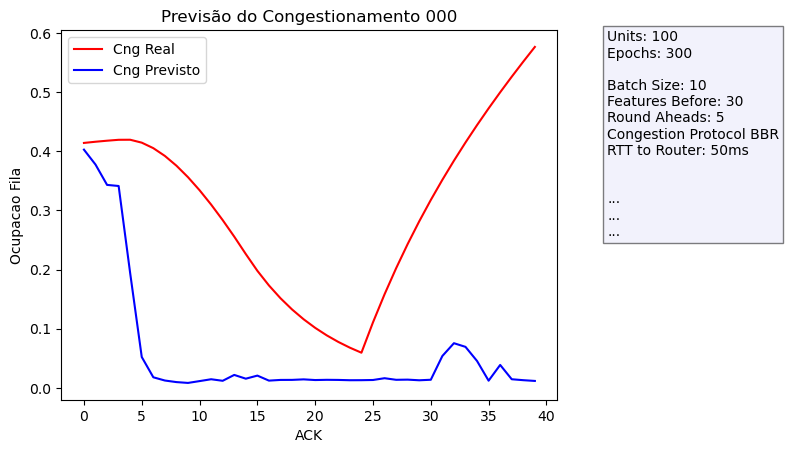

'./Exp_0000016/Thu_Jun__1_20_24_05_2023'

In [12]:
description = "testar com outros dados, mas gerados com uma topologia dumbell, igual a do treinamento."+"\n"  
description =description + "Média móvel da quantidade de pacotes na fila.\n"
description =description + "Modelo com 300 épocas em cada round\n"
description = description+ "Verificando a aderencia sobre um dos modelos concatenados\n"
description = description+ "Dados que não participaram do treinamento, mas gerados na mesma rede.\n"
#description = description+ "Na topologia considerada, ajustou-se os RTT entre os roteadores de 0,005ms, pois com roteadores, o processamento da fila faz com que demore mais.\n"
#description = description+ ".\n"
exp_dir = "./Exp_0000016/"
GeneralTraining(parExpDir="./Exp_0000016/",
                parPreviousTrainingExpDir=exp_dir,
                parTrainingPath="./Exp_0000016/training_client01.csv",
                parTestPath="./Exp_0000016/test_client01.csv",
                parExpDescription=description,
                parSequencialTraining=False)


Ainda não ficou bom. Vamos, levando-se em consideração que quando se treina com o conjunto todos de dados, a coisa fica perfeita, vamos aumentar o tamanho da janela deslizante para 50*T = 1500 e utilzar 100 épocas e 40 deslizamentos

In [ ]:
description = "testar com outros dados, mas gerados com uma topologia dumbell, igual a do treinamento."+"\n"  
description =description + "Média móvel da quantidade de pacotes na fila.\n"
description =description + "Modelo com 100 épocas em cada round\n"
description = description+ "Dados que participaram do treinamento por partes, e dados de treino como os da janela deslizante.\n"
#description = description+ "Na topologia considerada, ajustou-se os RTT entre os roteadores de 0,005ms, pois com roteadores, o processamento da fila faz com que demore mais.\n"
#description = description+ ".\n"
exp_dir = "./Exp_0000016/"
GeneralTraining(parExpDir="./Exp_0000016/",
                parPreviousTrainingExpDir=exp_dir,
                parTrainingPath="./Exp_0000016/training_client01.csv",
                parTestPath="./Exp_0000016/test_client01.csv",
                parExpDescription=description,
                parSequencialTraining=False)

##################Round  0  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780
1504
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (1470, 30, 4)
46/46 [==============================] - 3s 25ms/step
[[0.67810994 0.6801868  0.68613696 0.6574577  0.6789629 ]
 [0.67196    0.6795391  0.67694813 0.65112203 0.6659125 ]
 [0.6685613  0.6795508  0.67105    0.6476584  0.65568453]
 ...
 [0.77110296 0.75867283 0.7598285  0.7519657  0.7584982 ]
 [0.77638876 0.7591228  0.76199794 0.7522825  0.7619142 ]
 [0.77134746 0.7486321  0.74810493 0.73768675 0.751118  ]]
##################Round  1  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
1504
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normal

Pelos resultados preliminares, já parece q não vai ficar bom. Ainda tentando aproximar do treinamento tradicional, sem janela deslizante, vamos fazer o deslocamento só na calda, mantendo toda a série na mesma sequencia.

# @@@FIM

Não ficou bom. Vamos tentar mais hounds

##################Round  0  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 57ms/step
[[0.6059487  0.6105413  0.61704636 0.6050767  0.60437566]
 [0.5961256  0.60079175 0.6066416  0.5953906  0.5954816 ]
 [0.59000266 0.5946483  0.59969455 0.5892637  0.59018534]
 ...
 [0.41539595 0.41712874 0.41884276 0.41700462 0.41789025]
 [0.41560814 0.41733474 0.4190228  0.4171974  0.41811693]
 [0.41658917 0.4183137  0.41998452 0.4181476  0.41912967]]
##################Round  1  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:

ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 57ms/step
[[0.6191915  0.6188846  0.6184304  0.6189705  0.618568  ]
 [0.6124404  0.6120492  0.61164343 0.6120516  0.6116242 ]
 [0.61182654 0.611422   0.61102885 0.6114217  0.61100596]
 ...
 [0.02398716 0.02454987 0.02552412 0.02529385 0.02548883]
 [0.01983665 0.02049562 0.02145837 0.02103158 0.02146088]
 [0.0169413  0.01757081 0.01851513 0.01795106 0.01852382]]
##################Round  12  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 58ms/step
[[0.6137657  0.6139571  0.6136742  0.613

ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 63ms/step
[[0.6218019  0.6218686  0.6217926  0.6217437  0.6218682 ]
 [0.620854   0.62091124 0.62084156 0.62079203 0.62091404]
 [0.61990815 0.6199559  0.6198924  0.6198429  0.6199619 ]
 ...
 [0.01139438 0.01192487 0.01241674 0.01158006 0.01254897]
 [0.0113523  0.01188234 0.01238377 0.01152443 0.0125288 ]
 [0.01204923 0.01259159 0.01311694 0.01217156 0.01328653]]
##################Round  23  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 60ms/step
[[0.6267626  0.6269542  0.6267925  0.626

ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 68ms/step
[[0.5830395  0.5830529  0.5830681  0.5830457  0.58307356]
 [0.58287823 0.5828917  0.5829078  0.582885   0.5829136 ]
 [0.5826963  0.5827099  0.5827269  0.5827037  0.58273304]
 ...
 [0.01450869 0.01464294 0.01491581 0.01446274 0.01495159]
 [0.02042467 0.02054833 0.02076164 0.0203435  0.02077467]
 [0.6174137  0.617404   0.61745214 0.617415   0.6174488 ]]
##################Round  34  ##################################
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
304
ack_ewma_normalizer:  3208.75
send_ewma:  3267.72
rtt_ratio_normalizer:  11.623931623931623
cwnd (Bytes):  208780.0
Observe os testadores
shape:  (270, 30, 4)
9/9 [==============================] - 2s 71ms/step
[[0.5747976  0.5748158  0.57482475 0.574

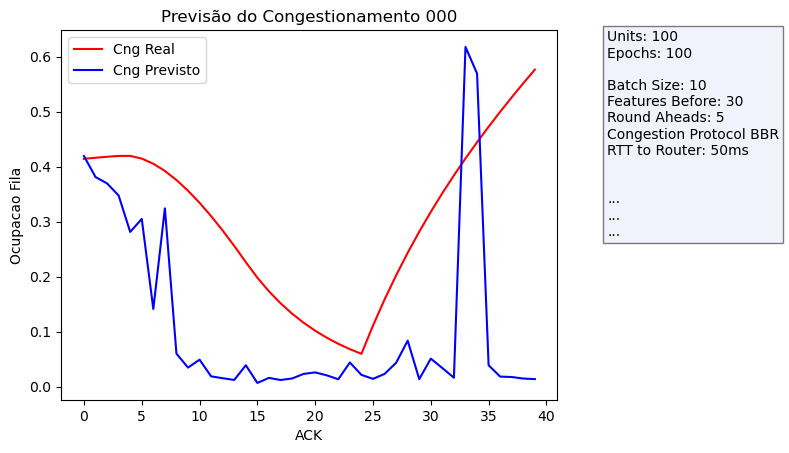

'./Exp_0000016/Thu_Jun__1_12_53_25_2023'

In [10]:
description = "testar com outros dados, mas gerados com uma topologia dumbell, igual a do treinamento."+"\n"  
description =description + "Média móvel da quantidade de pacotes na fila.\n"
description =description + "Modelo com 300 épocas em cada round\n"
description = description+ "Verificando a aderencia sobre um dos modelos concatenados\n"
description = description+ "Dados que não participaram do treinamento, mas gerados na mesma rede.\n"
#description = description+ "Na topologia considerada, ajustou-se os RTT entre os roteadores de 0,005ms, pois com roteadores, o processamento da fila faz com que demore mais.\n"
#description = description+ ".\n"
exp_dir = "./Exp_0000016/"
GeneralTraining(parExpDir="./Exp_0000016/",
                parPreviousTrainingExpDir=exp_dir,
                parTrainingPath="./Exp_0000016/training_client01.csv",
                parTestPath="./Exp_0000016/test_client01.csv",
                parExpDescription=description,
                parSequencialTraining=False)


Não ficou muito bom, vamos tentar aproximar o início dos dados, a cada round, das últimas features consideradas no treinamento.